<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/DeepLabv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF6804 Vision par ordinateur

Polytechnique Montréal

Author: Soufiane Lamghari




Description : This notebook implements DeepLabv3 for semantic segmentation in inference. Using ResNet-101 as the backbone network (pre-trained on the 21 classes of the Pascal VOC dataset), we predict the semantic segmentation of some sample images.

Import libraries

In [ ]:
from PIL import Image
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io
import os

Get images (here from the github of the INF6804 course) and transform them as torch tensors normalized with the mean and the standard deviation of ImageNet

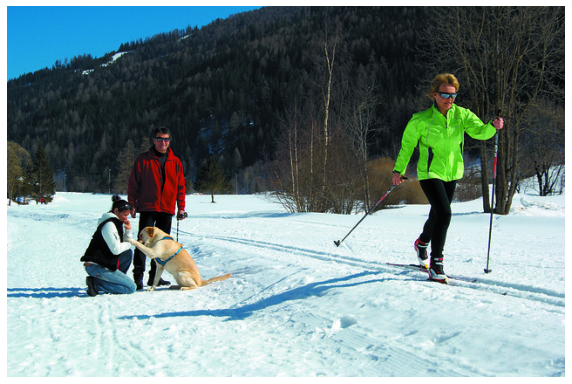

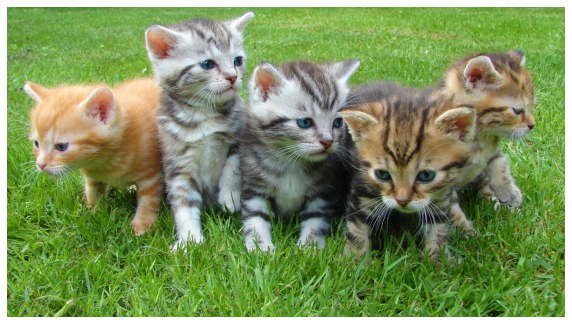

In [ ]:
source = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/images'

examples = ['ski.jpg', 'cats.jpg']

inputs=[]
sizes=[]
preprocess = transforms.Compose([
    transforms.Resize((512,512), interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

for example in examples:
  img = Image.fromarray(io.imread(os.path.join(source, example))) 
  input_tensor = preprocess(img)
  inputs.append(input_tensor)
  sizes.append(img.size)
  plt.figure(figsize = (10,10))
  plt.imshow(img); plt.axis('off'); plt.show()

input_batch = torch.stack(inputs, 0)
input_batch = input_batch.cuda()

Load the model and get the predictions, the backbone network is ResNet-101 pre-trained on the 21 classes of Pascal VOC. For each input image, the model outputs a tensor with 21 channels. Each channel is associated to a category.

In [ ]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
model.cuda()

with torch.no_grad():
    predictions = model(input_batch)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


This function is used to draw segmentation maps. it matches each class pixel with a specific color.

In [ ]:
def draw_segmentation_mask(image, nb_classes):
  name_colors=list(mcolors.CSS4_COLORS.keys())[7:7+nb_classes]
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  image.putpalette(rgb_colors)
  return image

Based on the prediction, we construct an image where each pixel corresponds to a class and we output the segmentation map using *draw_segmentation_mask()*

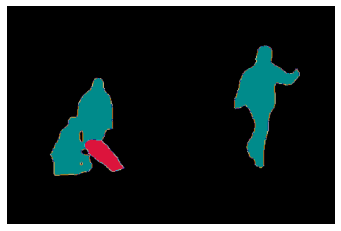

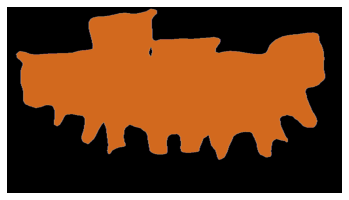

In [ ]:
class_number=predictions['out'].shape[1]

for i in range(len(inputs)):
  prediction = torch.argmax(predictions['out'][i].squeeze(), dim=0).detach().cpu().numpy().astype(np.uint8)
  masks = Image.fromarray(prediction).resize(sizes[i])
  segmentation_mask=draw_segmentation_mask(masks,class_number)
  plt.imshow(segmentation_mask); plt.axis('off'); plt.show()

**References:**

 - https://pytorch.org/docs/stable/torchvision/models.html

 - [Rethinking Atrous Convolution for Semantic Image Segmentation (DeepLabv3) paper](https://arxiv.org/abs/1706.05587) 